## Project 2: Analyze A/B Test Results

São Paulo, 15 may of 2019

Felipe Mahlmeister

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('source/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.loc[:,'user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].sum()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.loc[(df['group']!='treatment')&(df['landing_page']=='new_page') | \
       (df['group']=='treatment')&(df['landing_page']!='new_page'),'user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.loc[(df['group']=='treatment')&(df['landing_page']=='new_page') |\
             (df['group']=='control')&(df['landing_page']=='old_page'),:]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.loc[:,'user_id'].count()

290585

In [11]:
df2.loc[:,'user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.loc[df2['user_id'].duplicated(),['user_id']]

,user_id
2893,773192


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset=['user_id'], keep='first')

In [15]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.loc[:,'converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.loc[df2['group']=='control','converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.loc[df2['group']=='treatment','converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.loc[df2['landing_page']=='new_page',:].count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

#### According to the previous lines, there's 50% percent of chance of any individual receives a new page, and a probability of conversion of control and treatment group of 12.0% and 11.9%, respectively, therefore there's no evidence that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{old} - p_{new} \leq 0 $$
$$ H_1: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.loc[:,'converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.loc[:,'converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
# Number of users landing on the new page
n_new = df2.loc[df2['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
# Number of users landing on the old page
n_old = df2.loc[df2['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# Simulating samples with binomial distribution
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.sum()

17524

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# Simulating samples with binomial distribution
old_page_converted = np.random.binomial(1, p_old,n_old)
old_page_converted.sum()

17362

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# How many lines each n pages converted has?
new_page_converted.shape, old_page_converted.shape

((145310,), (145274,))

In [27]:
# According to above line, new_page_converted has more lines than old_page_converted, we need to equalize them:
new_page_converted = new_page_converted[:145274]

new_page_converted.mean() - old_page_converted.mean()

0.0010944835276787412

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    diffs = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diffs)

In [29]:
p_diffs = np.array(p_diffs)
p_diffs.mean()

-1.0257661343717268e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

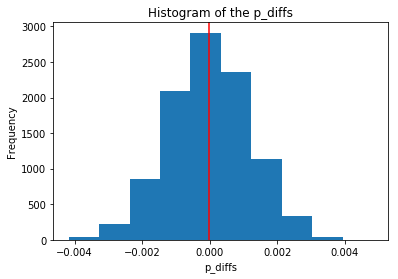

In [30]:
plt.hist(p_diffs);
plt.axvline(np.array(p_diffs).mean(), color='red');
plt.xlabel('p_diffs');
plt.ylabel('Frequency');
plt.title('Histogram of the p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
actual_diff = df2.loc[df2['group']=='treatment','converted'].mean()-df2.loc[df2['group']=='control','converted'].mean()
actual_diff

-0.0015782389853555567

In [32]:
(actual_diff < p_diffs).mean()

0.906

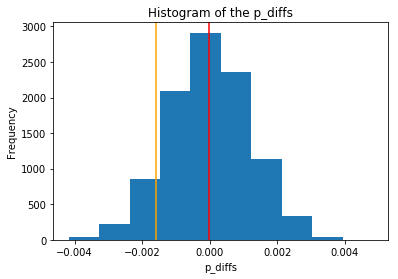

In [33]:
plt.hist(p_diffs);
plt.axvline(p_diffs.mean(), color='red');
plt.axvline(np.array(actual_diff).mean(), color='orange');
plt.xlabel('p_diffs');
plt.ylabel('Frequency');
plt.title('Histogram of the p_diffs');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

##### In scientific studies, this value is called as P-value, which is the probability of finding the observed, or more extreme results when the null hypothesis $(H_0)$ of a study question is true.
##### In our study, we find a very large P-value, which indicates weak evidence against the null hypothesis so we can conclude that there's no conversion advantage utilizing the new page, in other words, the null hypothesis is true.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
df2.loc[(df2['landing_page']=='new_page')&(df2['converted']==1)].shape[0]

17264

In [35]:
convert_old = df2.loc[(df2['landing_page']=='old_page')&(df2['converted']==1)].shape[0]
convert_new = df2.loc[(df2['landing_page']=='new_page')&(df2['converted']==1)].shape[0]
n_old = df2.loc[df2['group']=='control'].shape[0]
n_new = df2.loc[df2['group']=='treatment'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
#Two-sample Proportion Hypothesis Testing
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('z_score: {}'.format(z_score))
print('p_value: {}'.format(p_value))

z_score: 1.3109241984234394
p_value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [37]:
from scipy.stats import norm

# How significant our z-score is?
cdf_z_score = norm.cdf(z_score)
print('z_score: {}'.format(cdf_z_score))

# Define the critical value at the confidence interval of single-sided test
conf_int = 0.95
z_crit_value = norm.ppf(conf_int)
print('z_crit_value: {}'.format(z_crit_value))

z_score: 0.9050583127590245
z_crit_value: 1.6448536269514722


#### The z-critical value is greater than z-score, it indicates that we fail to reject the null hypothesis, which suggest the new page conversion rate is higher than the old page.

#### These values agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2.loc[:,'intercept'] = 1

df2[['control','treatment']] = pd.get_dummies(df2.loc[:,['group']])

df2['ab_page'] = df2['treatment']

df2 = df2.drop(columns=['treatment','control'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
LR = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = LR.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:42:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

#### The P-value associated with ab_page is 0.190.

#### Its value differ because of the methods utilized, on the first we calculated P-value with one-sided test and this logistic regression approach consider the two-sided test. In this case, we don't test anymore for not greater than or equal, instead we test for not equal in our hypothesis, as following:

$$H_0:p_{new} − p_{old} = 0$$

$$H_1:p_{new} − p_{old} \neq 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### By adding other factors to our regression model, we may be leading to unreliable and unstable estimates of regression coefficients (multicollinearity) in our model, which may affect our predictions.

#### Every time we include a new predictor variable we need to take the necessary steps in order to assure the reliability of the model/prediction.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('source/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(columns=['US'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
### Fit Your Linear Model And Obtain the Results

LR_2 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
results_2 = LR_2.fit()
print(results_2.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        12:42:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.

In [45]:
np.exp(results_2.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [46]:
1/_

0.00010001000100010001

In [47]:
df.groupby('group')['converted'].mean()

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

#### Conclusions: Logistic Regression 2

As could be seen on the above line, the inclusion of countries doesn't result in a significant effect on conversion rates for the control and treatment group.

<a id='conclusions'></a>
## Conclusions

#### According to the analyses performed, we can conclude that the performance of the old page was better, which was several times confirmed by different analyses that lead this same conclusion.

#### Hence, we accept the null hypothesis and reject the alternate hypothesis.